### Evaluation of Variational Autoencoder (VAE) for KDD CUP

## The Method

1. Prepare data & Partition the data into 80-20 train-test split
2. Define Models & Parameters
3. Perform Cross-Validation on the training data
3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters
4. Evaluate the (re)trained models on the test data
5. Final evaluation of the models

![The Method](method.png)

Source: [scikit-learn.org - Cross-validation](https://scikit-learn.org/1.5/modules/cross_validation.html#cross-validation-and-model-selection)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from pandas import DataFrame as df
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearn_pipeline # Use imblearn's pipeline
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import  BaseEstimator,ClassifierMixin

# Import ML libraries
import keras
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imbens.ensemble import SelfPacedEnsembleClassifier
from scikeras.wrappers import KerasClassifier
import keras_tuner
from keras import layers
from keras import ops
from keras import optimizers
import tensorflow as tf

from pprint import pprint
from time import time
import joblib

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
CROSS_VAL_SPLITS = 5
CKP_PREFIX = 'KDD_'

np.random.seed(RANDOM_STATE)

# pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### 1. Prepare data & Partition the data into 80-20 train-test split

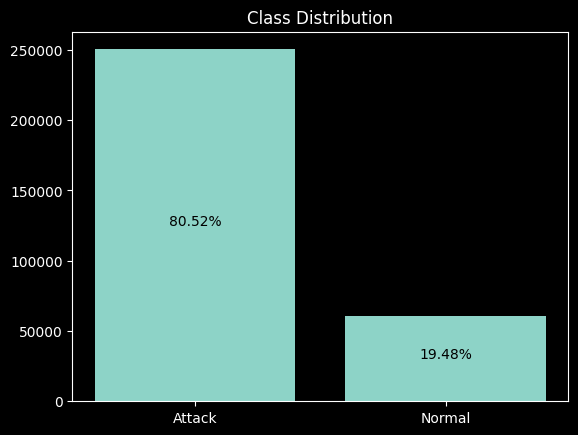

Label Mapping: {'attack': 0, 'normal': 1}
Weights:  {0: 4.991290198603437e-06, 1: 2.062961587655238e-05}
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
Transformed X_train shape: (248823, 121)


In [2]:
# Importing the dataset
path_to_data = '../data/kddcup/kddcup_data_corrected.csv'

# col names from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
col_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
]
# from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
categorical_cols = [
    "protocol_type",
    "service",
    "flag",
    "land",
    "logged_in",
    "is_host_login",
    "is_guest_login",
]

# Read data (10 % subset of the original dataset)
data = pd.read_csv(path_to_data, names=col_names, header=None)

# summarize attack types as "attack" for binary classification
data["label"] = data["label"].apply(lambda x: "attack" if x != "normal." else 'normal')

# Split data sets into X, y respectively
X = data.drop("label", axis=1)
y = data["label"]

# Visualize class imbalance
plt.bar(["Attack", "Normal"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1] / total) * 100
normal_percentage = (data["label"].value_counts()[0] / total) * 100

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage:.2f}%', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage:.2f}%', ha='center', color='black')
plt.title("Class Distribution")
plt.show()

# Encode labels (LabelEncoder is not part of the pipeline but applied directly to y)
le = LabelEncoder()
y = le.fit_transform(y)

# Extract label mapping
label_mapping = {label: index for index, label in enumerate(le.classes_)}
print("Label Mapping:", label_mapping)

# Define label mappings
normal_label = label_mapping['normal']
attack_label = label_mapping['attack']

# create training and test partitions with 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

## AE specific pre-processing: Only use negative samples for training
# X_train = X_train[y_train == normal_label].copy()
# neg_y_train = y_train[y_train == normal_label].copy()

# Fit OneHotEncoder to learn categories from the training data. This is necessary to ensure that the same categories are used for random splits during cross-validation
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype="int8")
one_hot_encoder.fit(X_train[categorical_cols])
learned_categories = one_hot_encoder.categories_

# Define numerical columns & indices
num_cols = data.drop(categorical_cols, axis=1)
num_indices = [data.columns.get_loc(col) for col in num_cols.drop('label', axis=1).columns]
cat_indices = [data.columns.get_loc(col) for col in categorical_cols]

# Set class weights
class_weight = {label[0]: 1.0 / count for label, count in df(y_train).value_counts().items()}
print("Weights: ", class_weight)

# Define preprocessing transformers and pipeline

# Numerical transformer. Scales numerical data using StandardScaler
numeric_transformer = imblearn_pipeline(
    steps=[("scaler", StandardScaler())], verbose=True
)
numeric_transformer.set_output(transform="pandas")

# Categorical transformer. Encodes categorical data using OneHotEncoder
categorical_transformer = imblearn_pipeline(
    steps=[
        (
            "onehot",
            OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=False,
                categories=learned_categories,
                dtype="int8",
            ),
        )
    ],
    verbose=True,
)
categorical_transformer.set_output(transform="pandas")

# Define preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_indices),
        ("cat", categorical_transformer, cat_indices),
    ],
    verbose=True,
)


# Check preprocessing pipeline and get target shape
transformed_sample = preprocessor.fit_transform(X_train)
print(f"Transformed X_train shape: {transformed_sample.shape}")

### 2. Define models and parameters

In [5]:
# VAE Keras Custom Model Class. Implementation based on Bank et al (2021)
@keras.saving.register_keras_serializable()
class VAE(keras.Model):
    def __init__(self, encoder, decoder, kl_beta=1, **kwargs):
        super().__init__(**kwargs)
        self.decoder = decoder
        self.encoder = encoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.kl_beta = (
            kl_beta  # weight to put more or less balance on reconstruction loss
        )

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    @tf.function
    def reconstruction_loss(self, x, f_z):
        # reconstruction_loss = keras.losses.binary_crossentropy(x, f_z)
        mse = keras.losses.MeanSquaredError()
        reconstruction_loss = mse(x, f_z)

        return reconstruction_loss

    @tf.function
    def loss_fn(self, x, f_z, z_mean, z_log_var):
        # Ensure reduction across the batch dimension
        reconstruction_loss = tf.reduce_mean(self.reconstruction_loss(x, f_z))

        # KL divergence calculation
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var + 1e-8), axis=1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        # total loss calculation
        total_loss = reconstruction_loss + (self.kl_beta * kl_loss)
        return total_loss, reconstruction_loss, kl_loss

    @staticmethod  # Define the encoder model. See Bank et al (2021, p 8)
    def get_encoder(
        data_dim,
        latent_dim,
        hidden_dims,
        activation=keras.layers.ReLU(),
        dropout_rate=0,
    ):
        """Encoder Net

        Takes input x and maps it into a mean and covariance that determine the approximate posterior distribution of the latent space.

        Args:
            data_dim (_type_): Input dimension. Usually equal to n features.
            latent_dim (_type_): Size of the bottleneck.
            hidden_dims: List of hidden dims, e.g., [20, 10, 8]
            activtion: Activtion function for hidden dims

        Returns:
            z_mean: Mean
            z_log_var: Covariance
        """
        # Input Layer
        inputs = layers.Input(shape=(data_dim,))

        # Hidden Layer for compression
        x = inputs
        for dim in hidden_dims:
            x = layers.Dense(dim)(x)
            x = activation(x)
            if dropout_rate != 0:
                x = layers.Dropout(dropout_rate)(x)

        # calculate mean g(x) and covariance h(x) of the distribution
        z_mean = layers.Dense(latent_dim)(x)
        z_log_var = layers.Dense(latent_dim)(x)

        return keras.Model(inputs, [z_mean, z_log_var], name="encoder")

    @staticmethod  # Define the decoder model f(z)
    def get_decoder(
        latent_dim,
        output_dim,
        hidden_dims,
        activation=keras.layers.ReLU(),
        dropout_rate=0,
    ):
        # take sample from latent space as input
        latent_inputs = layers.Input(shape=(latent_dim,))

        # Hidden Layer for reconstruction
        x = latent_inputs
        for dim in reversed(hidden_dims):
            x = layers.Dense(dim)(x)
            x = activation(x)
            if dropout_rate != 0:
                x = layers.Dropout(dropout_rate)(x)

        # output reconstruction
        outputs = layers.Dense(output_dim, activation="sigmoid")(x)
        return keras.Model(latent_inputs, outputs, name="decoder")

    def sampling(
        self, args
    ):  # Define the sampling function. See Bank et al (2021, p 8)
        """Sample from latent space by applying 'Reparameterization'

        Args:
            args (list): List of mean and covariance (z_mean, z_log_var)

        Returns:
            z: Sample from the latent space
        """
        # unpack mean g(x) and covariance h(x)
        z_mean, z_log_var = args

        # epsilon is a normal distribution: N(0, I)
        epsilon = keras.random.normal(shape=tf.shape(z_mean), seed=self.seed_generator)

        # Sampling via reparametrisation trick: z = h(x)  * espilon + g(x)
        return epsilon * ops.exp(z_log_var * 0.5) + z_mean

    @tf.function
    def train_step(self, data):
        # data = random minibatch of M datapoints
        x = data

        with tf.GradientTape() as tape:
            # encode input to mean g(x) and covariance h(x)
            z_mean, z_log_var = self.encoder(x)

            # sample random z from latent space
            z = self.sampling((z_mean, z_log_var))

            # decode z via f(z)
            f_z = self.decoder(z)

            # calculate reconstruction loss
            loss, reconstruction_loss, kl_loss = self.loss_fn(x, f_z, z_mean, z_log_var)

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.loss_tracker.update_state(loss)

        return {
            "loss": self.loss_tracker.result(),
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def test_step(self, data):
        x = data
        z_mean, z_log_var = self.encoder(x)

        z = self.sampling((z_mean, z_log_var))
        f_z = self.decoder(z)

        _, reconstruction_loss, _ = self.loss_fn(x, f_z, z_mean, z_log_var)
        return {
            "reconstruction_loss": reconstruction_loss,
        }

    def call(self, data):
        print("calling model with data shape: ", data.shape, " and type ", type(data))
        x = data
        z_mean, z_log_var = self.encoder(x)

        z = self.sampling((z_mean, z_log_var))
        f_z = self.decoder(z)

        return self.reconstruction_loss(x, f_z)

In [6]:
class VAESklearnEstimator(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        data_dim,
        latent_dim=80,
        learning_rate=1e-6,
        kl_beta=0.5,
        hidden_dims=[128, 128, 64],
        activation='relu',
        dropout_rate=0.0,
        optimizer='adam',
        cb_early_stopping_patience=15,
        batch_size=128,
        epochs=100,
        verbose=0,
        random_state=None,
        normal_label=1,
    ):
        self.data_dim = data_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.kl_beta = kl_beta
        self.hidden_dims = hidden_dims
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.cb_early_stopping_patience = cb_early_stopping_patience
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.random_state = random_state
        self.model_ = None,
        self.normal_label = normal_label

    def _build_model(self):
        # Map activation function
        if self.activation == 'relu':
            activation_fn = keras.layers.ReLU()
        elif self.activation == 'leaky_relu':
            activation_fn = keras.layers.LeakyReLU()
        else:
            raise ValueError(f"Unsupported activation function: {self.activation}")

        # Map optimizer
        if self.optimizer == 'adam':
            optimizer_fn = keras.optimizers.Adam(learning_rate=self.learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")

        # Build the encoder and decoder
        encoder = VAE.get_encoder(
            data_dim=self.data_dim,
            latent_dim=self.latent_dim,
            hidden_dims=self.hidden_dims,
            activation=activation_fn,
            dropout_rate=self.dropout_rate,
        )

        decoder = VAE.get_decoder(
            latent_dim=self.latent_dim,
            output_dim=self.data_dim,
            hidden_dims=self.hidden_dims,
            activation=activation_fn,
            dropout_rate=self.dropout_rate,
        )

        # Initialize VAE model
        vae = VAE(encoder, decoder, kl_beta=self.kl_beta)
        vae.compile(optimizer=optimizer_fn)
        return vae

    def fit(self, X, y=None):
        # Set random seed
        if self.random_state is not None:
            tf.keras.utils.set_random_seed(self.random_state)

        # Train only on normal samples
        # if y is not None:
        #     print("Training on normal samples only. All other samples will be ignored. Normal label: ", self.normal_label)
        #     print("Size of X before filtering: ", len(X))
        #     X = X[y == self.normal_label].copy()
        #     y = y[y == self.normal_label].copy()
        #     print("Size of X after filtering: ", len(X))
        #     if len(X) == 0:
        #         raise ValueError("No normal samples found in training data")

        X = np.array(X)

        # Build the model
        self.model_ = self._build_model()

        # Define callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor="reconstruction_loss",
                mode="min",
                patience=self.cb_early_stopping_patience
            )
        ]

        # Fit the model
        self.model_.fit(
            X,
            batch_size=self.batch_size,
            epochs=self.epochs,
            callbacks=callbacks,
            verbose=self.verbose,
        )
        return self

    def predict(self, X):
        X = np.array(X)
        batch_size = self.batch_size
        n_samples = X.shape[0]
        reconstruction_losses = []

        # debug
        print("Predicting on X with shape: ", X.shape)
        print("Batch size: ", batch_size)
        print("Number of samples: ", n_samples)
        print("Reconstruction losses: ", reconstruction_losses)

        for i in range(0, n_samples, batch_size):
            print("Processing batch: ", i)
            X_batch = X[i:i + batch_size]
            print("Batch shape: ", X_batch.shape)
            print("Batch type: ", type(X_batch))
            reconstruction_loss = self.model_.call(X_batch)

            # Convert to NumPy array if it's a tensor
            if hasattr(reconstruction_loss, 'numpy'):
                reconstruction_loss = reconstruction_loss.numpy()

            # Check if reconstruction_loss is a scalar or an array
            if np.isscalar(reconstruction_loss):
                reconstruction_losses.append(reconstruction_loss)  # Append if it's a scalar
            else:
                reconstruction_losses.extend(reconstruction_loss)  # Extend if it's an array

        print("Reconstruction losses: ", reconstruction_losses)

        return np.array(reconstruction_losses)

    def predict_proba(self, X):
        X = np.array(X)
        reconstruction_loss = self.model_.call(X)

        # Normalize reconstruction loss to [0,1]
        scores = (reconstruction_loss - ops.min(reconstruction_loss)) / (
            ops.max(reconstruction_loss) - ops.min(reconstruction_loss)
        )

        # Return probability estimates
        return np.vstack([1 - scores, scores]).T

    def score(self, X, y):
        y_pred = self.predict(X)
        return f1_score(y, y_pred)

In [7]:
vae_estimator = VAESklearnEstimator(
    data_dim=transformed_sample.shape[1],
    latent_dim=80,
    learning_rate=1e-6,
    kl_beta=0.5,
    hidden_dims=[128, 128, 64],
    activation='relu',
    dropout_rate=0.0,
    optimizer='adam',
    cb_early_stopping_patience=5,
    batch_size=128,
    epochs=15,
    verbose=1,
    random_state=RANDOM_STATE,
	normal_label=normal_label
)

# create pipeline
vae_pipeline = Pipeline([
	('preprocessor', preprocessor),
	('vae', vae_estimator)
])
display(vae_pipeline)

# Define pipelie for RandomSearchCV
vae_rs_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("rs_tuned_vae", vae_estimator)
    ]
)
print("RandomSearchCV MLP pipeline:")
display(vae_rs_pipeline)

# Define multimetric scoring
scoring = {
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
}

# Define parameter grid
parameter_grid = {
    "rs_tuned_vae__batch_size": [128, 256],
    "rs_tuned_vae__epochs": [50, 100],
    "rs_tuned_vae__learning_rate": [0.00001, 0.000001],
    "rs_tuned_vae__kl_beta": [0.5, 1],
    "rs_tuned_vae__hidden_dims": [[128, 128, 64], [256, 128, 64]],
    "rs_tuned_vae__activation": ["relu", "leaky_relu"],
    "rs_tuned_vae__dropout_rate": [0.0, 0.2],
    "rs_tuned_vae__optimizer": ["adam"],
    "rs_tuned_vae__cb_early_stopping_patience": [10, 15],
    "rs_tuned_vae__latent_dim": [80, 100, 120],
	"rs_tuned_vae__cb_early_stopping_patience": [5, 15],
}

# Randomized search with k-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=vae_rs_pipeline,
    param_distributions=parameter_grid,
    n_iter=10,  # Define the number of random samples to try
    scoring=scoring,
    refit="f1",  # Refit on F1 score after finding the best parameters
    cv=StratifiedKFold(n_splits=5),  # 5-fold cross-validation
    verbose=1,
    n_jobs=1, # 1 job to avoid conflicts with un-serializable objects and pickling
    random_state=RANDOM_STATE,
    error_score="raise",
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  [0, 4, 5, 7, 8, 9, 10, 12, 13,
                                                   14, 15, 16, 17, 18, 19, 22,
                                                   23, 24, 25, 26, 27, 28, 29,
                                                   30, 31, 32, 33, 34, 35, 36, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[array(['icmp', 'tcp', 'udp'], dtype=object),
                                                                                             array(['IRC', 'X11', 'Z39_50', '...
                                                                                             array(['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3',
       'SF', 'SH'], dtype=object),
                                                                                             array([0, 1]),
                                                                                             array([0, 1]),
                                                                                             array([0, 1]),
                                                                                             array([0, 1])],
                                                                                 dtype='int8',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))],
                                                           verbose=True),
                                                  [1, 2, 3, 6, 11, 20, 21])],
                                   verbose=True)),
                ('vae',
                 VAESklearnEstimator(cb_early_stopping_patience=5, data_dim=121,
                                     epochs=15, random_state=42, verbose=1))])

RandomSearchCV MLP pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  [0, 4, 5, 7, 8, 9, 10, 12, 13,
                                                   14, 15, 16, 17, 18, 19, 22,
                                                   23, 24, 25, 26, 27, 28, 29,
                                                   30, 31, 32, 33, 34, 35, 36, ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(categories=[array(['icmp', 'tcp', 'udp'], dtype=object),
                                                                                             array(['IRC', 'X11', 'Z39_50', '...
                                                                                             array(['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3',
       'SF', 'SH'], dtype=object),
                                                                                             array([0, 1]),
                                                                                             array([0, 1]),
                                                                                             array([0, 1]),
                                                                                             array([0, 1])],
                                                                                 dtype='int8',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))],
                                                           verbose=True),
                                                  [1, 2, 3, 6, 11, 20, 21])],
                                   verbose=True)),
                ('rs_tuned_vae',
                 VAESklearnEstimator(cb_early_stopping_patience=5, data_dim=121,
                                     epochs=15, random_state=42, verbose=1))])

In [ ]:
vae_pipeline.fit(X_train[y_train == normal_label], y_train[y_train == normal_label])

In [ ]:
normal_losses = vae_pipeline.predict(X_test[y_test == normal_label])
anomaly_losses = vae_pipeline.predict(X_test[y_test == attack_label])

print(f"Average reconstruction loss for normal samples: {np.mean(normal_losses)}")
print(f"Average reconstruction loss for anomaly samples: {np.mean(anomaly_losses)}")

In [ ]:
# Initialize lists to store metrics for each CV run
precision_scores = []
recall_scores = []
f1_scores = []

for i, (train_idx, test_idx) in enumerate(StratifiedKFold(n_splits=5).split(X_train, y_train)):
    print(f"[CV {i+1} ...]")
    # Adjust indexing based on whether y_train is a DataFrame/Series
    y_train_train_normal = y_train.iloc[train_idx] if isinstance(y_train, pd.DataFrame) else y_train[train_idx]
    y_train_test_normal = y_train.iloc[test_idx] if isinstance(y_train, pd.DataFrame) else y_train[test_idx]

    print(f"Train normal samples: {len(y_train_train_normal[y_train_train_normal == normal_label])}")
    print(f"Test normal samples: {len(y_train_test_normal[y_train_test_normal == normal_label])}")

    # If X_train is a DataFrame
    if isinstance(X_train, pd.DataFrame):
        X_train_split = X_train.iloc[train_idx]
        X_test_split = X_train.iloc[test_idx]
    else:  # If X_train is a numpy array
        X_train_split = X_train[train_idx]
        X_test_split = X_train[test_idx]

    y_train_split = y_train[train_idx]
    y_test_split = y_train[test_idx]

    # Fit the pipeline
    vae_pipeline.fit(X_train_split[y_train_split == normal_label], y_train_split[y_train_split == normal_label])

    # Predict on the test set
    y_pred = vae_pipeline.predict(X_test_split)
    
    print(f"type of y_pred: {type(y_pred)}")
    if not isinstance(y_pred, np.ndarray):
        y_pred = np.array(y_pred)

    # Calculate metrics
    precision = precision_score(y_test_split, y_pred, average='binary')  # Adjust 'average' as needed (e.g., 'macro' for multi-class)
    recall = recall_score(y_test_split, y_pred, average='binary')  # Adjust 'average' as needed
    f1 = f1_score(y_test_split, y_pred, average='binary')  # Adjust 'average' as needed

    # Append metrics for this CV run
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Calculate mean and standard deviation for each metric
precision_mean = np.mean(precision_scores)
precision_std = np.std(precision_scores)

recall_mean = np.mean(recall_scores)
recall_std = np.std(recall_scores)

f1_mean = np.mean(f1_scores)
f1_std = np.std(f1_scores)

# Print the results
print(f"Precision: {precision_mean:.2f} ± {precision_std:.2f}")
print(f"Recall: {recall_mean:.2f} ± {recall_std:.2f}")
print(f"F1-Score: {f1_mean:.2f} ± {f1_std:.2f}")